In [1]:
import numpy as np
import pandas as pd
from termcolor import colored, cprint
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, max_error, mean_squared_log_error
import matplotlib.pyplot as plt
import math

# 🕵️‍♂️ Explorace dat 🔍
Pokud blíže prozkoumáme dataset, zjistíme, že mezi chybějícími hodnotami jsou **věk**, **kajuta**,**cena za lístek**, **místo nalodění** a **bydliště**. 

In [2]:
data = pd.read_csv('data.csv')
display(data.isnull().sum(axis=0))
data.columns=data.columns.str.strip()

ID             0
survived       0
pclass         0
name           0
sex            0
age          201
sibsp          0
parch          0
ticket         0
fare           1
cabin        773
embarked       2
home.dest    435
dtype: int64

### ⚓ Doplnění místa nalodění 

Můžeme si všimnout, že pouze u dvou záznamů chybí informace o místě nalodění, jelikož by místo nalodění nemuselo mít takový vliv na přežití pasažérů, nahradíme chybející hodnoty například modus hodnotou pro místo nalodění.

In [3]:
print("Což je ", colored("'"+data['embarked'].mode(dropna=True)[0]+"'", 'red', attrs=['bold']), sep='')
data['embarked'].fillna(data['embarked'].mode(dropna=True)[0], inplace=True)
data['embarked'] = data['embarked'].astype('category')
embarked_mapper = { 'C': 0, 'Q': 1, 'S': 2 }

Což je 'S'


Další hodnotou je cena za lístek, kde chybí jediný záznam. Doplnit ho čistě průměrnou hodnotou by mohl být problém, vzhledem k tomu, že cena lístku může korelovat například s tím, na jaké palubě byla pasažérova kajuta, což by teoreticky mohlo ovlivnit i jeho šanci na přežití. Doplníme tedy alespoň průměrnou cenu lístku v závislosti na passenger class.

### 🎟️ Doplnění ceny za lístek

In [4]:
avg_price = data[['pclass', 'fare']].groupby('pclass').mean(numeric_only=True).round().to_dict()['fare']
print(avg_price)

{1: 88.0, 2: 22.0, 3: 13.0}


In [5]:
def set_class_mean(x):
    if np.isnan(x['fare']):
        ret urn avg_price[x['pclass']]
    else:
        return x['fare']

In [6]:
data['fare'] = data.apply(lambda x: set_class_mean(x), axis=1)

Dále by se dalo spekulovat o tom, že **jméno** a **cílová destinace** (jelikož ledovec tam neměl nikdo) nebude hrát takovou roli při přežití.

In [7]:
data = data.drop(columns=['name', 'home.dest'])

Teď už stačí "jenom" doplnit **věk** a **kajutu**, problém ale je, že doplnění kajuty by byla těžká úloha, nehledě na to, že samotné rozložení kajut Titanicu je těžce dohledatelné.

In [8]:
display(data.isnull().sum(axis=0))

ID            0
survived      0
pclass        0
sex           0
age         201
sibsp         0
parch         0
ticket        0
fare          0
cabin       773
embarked      0
dtype: int64

### 🛏️ Doplnění kajuty

Vystačíme si tedy alespoň s palubou, na které se kajuta nacházela. Ta je značená prvním písmenem v záznamu o kajutě. Problém je ale ten, že některé hodnoty pokojů nejsou vyplněné

In [9]:
data['floor'] = data['cabin'].apply(lambda x: x[0] if isinstance(x, str) else x)
print("Paluby:")
print(colored('' + str(data['floor'].unique().tolist())+' ','magenta', attrs=['bold']))
display(data.isnull().sum(axis=0))

Paluby:
[nan, 'B', 'C', 'A', 'F', 'D', 'E', 'G'] 


ID            0
survived      0
pclass        0
sex           0
age         201
sibsp         0
parch         0
ticket        0
fare          0
cabin       773
embarked      0
floor       773
dtype: int64

Pokud budeme uvažovat fakt, že cena lístku, paluba na které byl pasažér ubytován a jeho třída spolu souvisí a navíc, pokud převedeme identifikátor paluby na uspořádanou množinu čísel (sestupně od nejlepší po nejhorší) pracujeme vlastně se třemi číselnými hodnotami a málo daty - na to by se mohla hodit **lineární regrese**.

In [10]:
tmp = data[data.fare > 0]
tmp = tmp[tmp.floor.notnull()]
tmp = tmp[['fare','pclass', 'floor']]
floor_mapper = dict( zip(tmp['floor'].astype('category'),tmp['floor'].astype('category').cat.codes))
tmp['floor'] = tmp['floor'].astype('category').cat.codes 
X = tmp.drop(columns='floor').values
y = tmp['floor'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [11]:
floor_mapper

{'B': 1, 'C': 2, 'A': 0, 'F': 5, 'D': 3, 'E': 4, 'G': 6}

In [12]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(colored(' Mean Absolute Error:\t\t','magenta',  attrs=['bold']), metrics.mean_absolute_error(y_test, y_pred))  
print(colored(' Mean Squared Error:\t\t','magenta',  attrs=['bold']), metrics.mean_squared_error(y_test, y_pred))  
print(colored(' Root Mean Squared Error:\t','magenta', attrs=['bold']), np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(colored(' Max Error:\t\t\t','magenta', attrs=['bold']), np.sqrt(metrics.max_error(y_test, y_pred)))

 Mean Absolute Error:		 0.7748874106476158
 Mean Squared Error:		 0.9869037601944908
 Root Mean Squared Error:	 0.9934302996156755
 Max Error:			 1.5089182176752163


Podle výsledků chyby na testovacích datech se tento model _"splete"_ maximálě o jedno podlaží, pokud budeme hodnotu vrácenou modelem zaokrouhlovat (protože ve výsledku potřebujeme diskrétní množinu s hodnotami 1-7). Tento postup asi není ideální, ale vzhledem k počtu záznamů a faktu, že i přes velkou snahu se mi nepodařilo vytrénovat model s **logistickou regresí** , který by měl stejnou, nebo menší chybovost (~10x větší chybovost) je tento způsob sofistikovanější a podle mě stále přesnější než doplnění průměrnou hodnotou

In [13]:
floors = ['A', 'B', 'C', 'D', 'E', 'F']

In [14]:
def assign_floor(row):
    if not isinstance(row['floor'], str):
        value = None
        try:
            value = int(math.floor(reg.predict([[row['fare'],row['pclass']]])[0]))
            # ošetření spodní hranice
            if value<0:
                value = 0
            # ošetření horní hranice
            elif value >len(floors):
                value = len(floors)-1
            row['floor'] = floors[value]
        except BaseException:
            # jenom pro jistotu
            row['floor'] = np.NaN
    return row

In [15]:
data = data.apply(lambda row: assign_floor(row), axis=1)
data.drop(columns='cabin', inplace=True)

### 🎆 Doplnění věku
Teď už jsou chybějící hodnoty pouze u sloupce s **věkem**. Nejdříve tedy odfiltrujeme ty záznamy, které nemají vyplněný věk.

In [16]:
knn_data = data[data['age'].notnull()].drop(columns=['ID', 'survived', 'ticket'])
knn_data['sex'] = knn_data['sex'].astype('category').cat.codes
knn_data['embarked'] = knn_data['embarked'].astype('category').cat.codes
knn_data['floor'] = knn_data['floor'].astype('category').cat.codes

In [17]:
knn_data.head()

,pclass,sex,age,sibsp,parch,fare,embarked,floor
0,3,0,22.0,0,0,7.7500,2,5
2,1,0,19.0,1,0,91.0792,0,1
3,3,1,25.0,0,0,7.2250,0,5
5,1,1,27.0,0,2,211.5000,0,2
6,1,0,24.0,3,2,263.0000,2,2


In [18]:
def split_data(Xdata, ydata, ratio=0.25, rd_seed=5656):
    Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=ratio, random_state=rd_seed) 
    Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=ratio, random_state=rd_seed) 
    return Xtrain, Xtest, Xval, ytrain, ytest, yval

In [19]:
Xtrain, Xtest, Xval, ytrain, ytest, yval = split_data(knn_data.drop(columns=['age']), knn_data.age)

Nejdříve nalezneme nejlepší model, který nám pomůže predikovat hodnotu s co největší přesností.

### 🏘️🏠 k Nearest Neighbors

In [20]:
param_grid = {
    'n_neighbors' : range(1,20),
    'p': range(1,5),
    'weights': ['uniform', 'distance']
}

param_comb = ParameterGrid(param_grid)

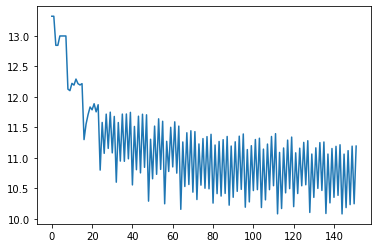

In [21]:
from sklearn.neighbors import KNeighborsRegressor
knn_val_acc = []
for params in param_comb:
        dt = KNeighborsRegressor(**params)
        dt.fit(Xtrain, ytrain)
        ypred = dt.predict(Xval)
        knn_val_acc.append(metrics.mean_absolute_error(yval, ypred))
a = plt.plot(knn_val_acc)

In [22]:
best_params = param_comb[np.argmin(knn_val_acc)]
print(colored('kNN', 'magenta', attrs=['bold']))
print("Nejlepší configurace: ", end='')
print(colored(best_params, 'green'))
best_kNN = KNeighborsRegressor(**best_params)
best_kNN.fit(Xtrain, ytrain)
print('Mean Absolute Error: ', end='')
print(colored(metrics.mean_absolute_error(ytest, best_kNN.predict(Xtest)), 'magenta'))

kNN
Nejlepší configurace: {'weights': 'uniform', 'p': 1, 'n_neighbors': 19}
Mean Absolute Error: 10.30307


### 🎄🌳🌴 Random Forest 

In [23]:
param_grid = {
    'n_estimators': range(1,100,5),
    'max_depth': range(1,5),
    'max_features': range(1,8)
}
param_comb = ParameterGrid(param_grid)

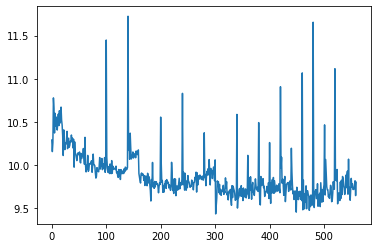

In [24]:
from sklearn.ensemble import RandomForestRegressor
rfreg_val_acc = []
for params in param_comb:
    dt = RandomForestRegressor(**params)
    dt.fit(Xtrain, ytrain)
    rfreg_val_acc.append(metrics.mean_absolute_error(yval, dt.predict(Xval)))
a = plt.plot(rfreg_val_acc)    

In [25]:
print(colored('Random Forest Regressor', 'magenta', attrs=['bold']))
best_params = param_comb[np.argmin(rfreg_val_acc)]
print("Nejlepší configurace: ", end='')
print(colored(best_params, 'green'))
bestRFR = RandomForestRegressor(**best_params)
bestRFR.fit(Xtrain, ytrain)
print('Mean Absolute Error:  ', end='')
print(colored(metrics.mean_absolute_error(yval, bestRFR.predict(Xval)), 'magenta'))

Random Forest Regressor
Nejlepší configurace: {'n_estimators': 6, 'max_features': 2, 'max_depth': 3}
Mean Absolute Error:  9.739871832786248


Z výsledků můžeme vidět, že **Random Forest** má v průměru menší chybu než **kNN**. Veznene tedy **RF** a doplníme jím chybějící hodnoty věku.

In [26]:
def assign_age(row):
    if math.isnan(row['age']):
        row['age'] = bestRFR.predict(row[['pclass', 'sex_v', 'sibsp', 'parch', 'fare', 'embarked_v', 'floor_v']].values.reshape(1, -1))[0]
    return row

In [27]:
data['age'].describe()

count    799.000000
mean      29.827180
std       14.441849
min        0.166700
25%       21.000000
50%       28.000000
75%       39.000000
max       80.000000
Name: age, dtype: float64

In [28]:
sex_mapper = { 'female': 0, 'male': 1 }

In [29]:
data['sex_v'] = data['sex'].astype('category').cat.codes
data['embarked_v'] = data['embarked'].astype('category').cat.codes
data['floor_v'] = data['floor'].astype('category').cat.codes
data = data.apply(lambda x: assign_age(x), axis=1)
data['age'] = data['age'].astype('int')

In [30]:
data.head()

,ID,survived,pclass,sex,age,sibsp,parch,ticket,fare,embarked,floor,sex_v,embarked_v,floor_v
0,0,1,3,female,22,0,0,347081,7.7500,S,F,0,2,5
1,1,0,3,male,28,0,0,330877,8.4583,Q,F,1,1,5
2,2,1,1,female,19,1,0,11967,91.0792,C,B,0,0,1
3,3,0,3,male,25,0,0,2672,7.2250,C,F,1,0,5
4,4,0,3,male,28,0,0,368573,7.7500,Q,F,1,1,5


In [31]:
data['age'].describe()

count    1000.000000
mean       29.341000
std        13.162978
min         0.000000
25%        22.000000
50%        28.000000
75%        36.000000
max        80.000000
Name: age, dtype: float64

Průměrný věk se nám extrémně nezměnil, vypadá to dobře.

In [32]:
data['ticket'] = data['ticket'].str.replace('[^0-9]', '')
data['ticket'] = data['ticket'].apply(lambda x: '-1' if not x else x).astype('int')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
ID            1000 non-null int64
survived      1000 non-null int64
pclass        1000 non-null int64
sex           1000 non-null object
age           1000 non-null int64
sibsp         1000 non-null int64
parch         1000 non-null int64
ticket        1000 non-null int64
fare          1000 non-null float64
embarked      1000 non-null object
floor         1000 non-null object
sex_v         1000 non-null int64
embarked_v    1000 non-null int64
floor_v       1000 non-null int64
dtypes: float64(1), int64(10), object(3)
memory usage: 109.5+ KB


V datasetu už tedy snad nemáme žádné prázdné hodnoty.

# Predikce přežití

### Výběr lepšího modelu
Dataset si rozdělíme na **trénovací**, **testovací** a **validační**. A zjistíme, jestli bude pro klasifikaci lepší použít **klasický klasifikační strom**, nebo **AdaBoost**

In [34]:
Xtrain, Xtest, Xval, ytrain, ytest, yval = split_data(data.drop(columns=['survived', 'ID', 'embarked', 'floor', 'sex']), data.survived)

### Klasický klasifikační strom

In [35]:
from sklearn.tree import DecisionTreeClassifier
clfDTC = DecisionTreeClassifier()
clfDTC.fit(Xtrain, ytrain)
print('Trénovací úspěšnost: '+colored('{0:.4f}'.format(metrics.accuracy_score(ytrain, clfDTC.predict(Xtrain))), 'red'))
print('Testovací úspěšnost: '+colored('{0:.4f}'.format(metrics.accuracy_score(ytest, clfDTC.predict(Xtest))), 'blue'))
print('Validační úspěšnost: '+colored('{0:.4f}'.format(metrics.accuracy_score(yval, clfDTC.predict(Xval))), 'green' ))

Trénovací úspěšnost: 1.0000
Testovací úspěšnost: 0.7160
Validační úspěšnost: 0.7181


### AdaBoost

In [36]:
from sklearn.ensemble import AdaBoostClassifier
param_grid = {
    'n_estimators': range(1,100,5),
    'learning_rate': [ x/100 for x in range(1,100, 5)]+[1],
    'algorithm': ['SAMME', 'SAMME.R']
}
param_comb = ParameterGrid(param_grid)
val_acc = []
for params in param_comb:
    dt = AdaBoostClassifier(**params)
    dt.fit(Xtrain, ytrain)
    val_acc.append(math.sqrt(metrics.mean_squared_error(yval, dt.predict(Xval))))
best_params = param_comb[np.argmin(val_acc)]

In [37]:
print(colored('AdaBoost', 'magenta', attrs=['bold']))
print("Nejlepší configurace: ", end='')
print(colored(best_params, 'green'))
clfABC = AdaBoostClassifier(**best_params)
clfABC.fit(Xtrain, ytrain)
print('Trénovací úspěšnost: '+colored('{0:.4f}'.format(metrics.accuracy_score(ytrain, clfABC.predict(Xtrain))), 'red'))
print('Testovací úspěšnost: '+colored('{0:.4f}'.format(metrics.accuracy_score(ytest, clfABC.predict(Xtest))), 'blue'))
print('Validační úspěšnost: '+colored('{0:.4f}'.format(metrics.accuracy_score(yval, clfABC.predict(Xval))), 'green'))

AdaBoost
Nejlepší configurace: {'n_estimators': 56, 'learning_rate': 0.31, 'algorithm': 'SAMME.R'}
Trénovací úspěšnost: 0.8310
Testovací úspěšnost: 0.7600
Validační úspěšnost: 0.8138


In [38]:
data['predicted'] = clfABC.predict(data.drop(columns=['survived', 'ID', 'embarked', 'floor', 'sex']))
data['correct'] = data.apply(lambda x: 1 if x['predicted'] == x['survived'] else 0, axis=1)

In [39]:
print("Úspěšnost predikce našeho modelu na trénovacím datasetu je "+colored(' '+str(data['correct'].sum()/len(data))+' ', 'blue', 'on_white', attrs=['bold']))

Úspěšnost predikce našeho modelu na trénovacím datasetu je  0.81 


## A teď celé ještě jednou

In [80]:
data = pd.read_csv('evaluation.csv')
data.columns=data.columns.str.strip()
data.drop(columns=['home.dest', 'name'], inplace=True)
display(data.isnull().sum(axis=0))

ID            0
pclass        0
sex           0
age          62
sibsp         0
parch         0
ticket        0
fare          0
cabin       241
embarked      0
dtype: int64

In [81]:
data['embarked'] = data['embarked'].astype('category')
data['ticket'] = data['ticket'].str.replace('[^0-9]', '')
data['ticket'] = data['ticket'].apply(lambda x: '-1' if not x else x).astype('int')
data['sex_v'] = data['sex'].replace(sex_mapper)
data['embarked_v'] = data['embarked'].replace(embarked_mapper)

Při prvním pokusu jsem zjistil, že jeden pasažér bydlí v kajutě **T**, se kterou jsme ale předtím nepočítali... <br>
Můžeme ale použít model pro určení paluby, nastavíme mu tedy **cabin** na **nan** 

In [82]:
data[ data['cabin'].notna() & data['cabin'].str.contains('T')]

,ID,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,sex_v,embarked_v
130,1130,1,male,45.0,0,0,113784,35.5,T,S,1,2


In [83]:
data.loc[data['ID']==1130, 'cabin'] = np.nan

In [84]:
data['floor'] = data['cabin'].apply(lambda x: x[0] if isinstance(x, str) else x)
data = data.apply(lambda row: assign_floor(row), axis=1)
data['floor_v'] = data['floor'].replace(floor_mapper).astype('int')
data.drop(columns=['sex', 'embarked', 'floor', 'cabin'], inplace=True)
data = data.apply(lambda x: assign_age(x), axis=1)
data['age'] = data['age'].astype('int')

In [85]:
data['prediction'] = clfABC.predict(data.drop(columns=['ID']))

In [86]:
data['ID']=data['ID'].astype('int')

In [87]:
print("Náš model právě zachránil " + colored(' '+ str(data['prediction'].sum()) +' ', 'red', 'on_yellow', attrs=['bold']) + " lidí!")

Náš model právě zachránil  101  lidí!


![Hooray!](giphy.webp "Hooray!")
<p align="justify"> Snad byl i úspěšný..</p>

In [88]:
data[['ID', 'prediction']].to_csv('results.csv', index=False)